In [1]:
#Import libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.util import ngrams

import string
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

import gensim
from gensim.models import Word2Vec

from wordcloud import WordCloud, STOPWORDS

np.random.seed(0)

%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [98]:
def timestamp_to_hour(x):
    x = pd.to_datetime(x)
    timestamp = x.strftime('%Y-%m-%d %H:00')
    return timestamp

### Tweet counts by hour

In [182]:
df_counts = pd.read_csv('data/tweet_counts.csv')  
df_counts.head(2)

,start,end,count
0,2022-01-22T00:09:51.000Z,2022-01-22T01:00:00.000Z,16166
1,2022-01-22T01:00:00.000Z,2022-01-22T02:00:00.000Z,18475


In [183]:
df_counts['start'] = df_counts['start'].apply(timestamp_to_hour)
df_counts['end'] = df_counts['end'].apply(timestamp_to_hour)
df_counts.drop(columns='end', inplace=True)
df_counts.set_index('start', inplace=True)
df_counts.head(2)

,count
start,
2022-01-22 00:00,16166
2022-01-22 01:00,18475


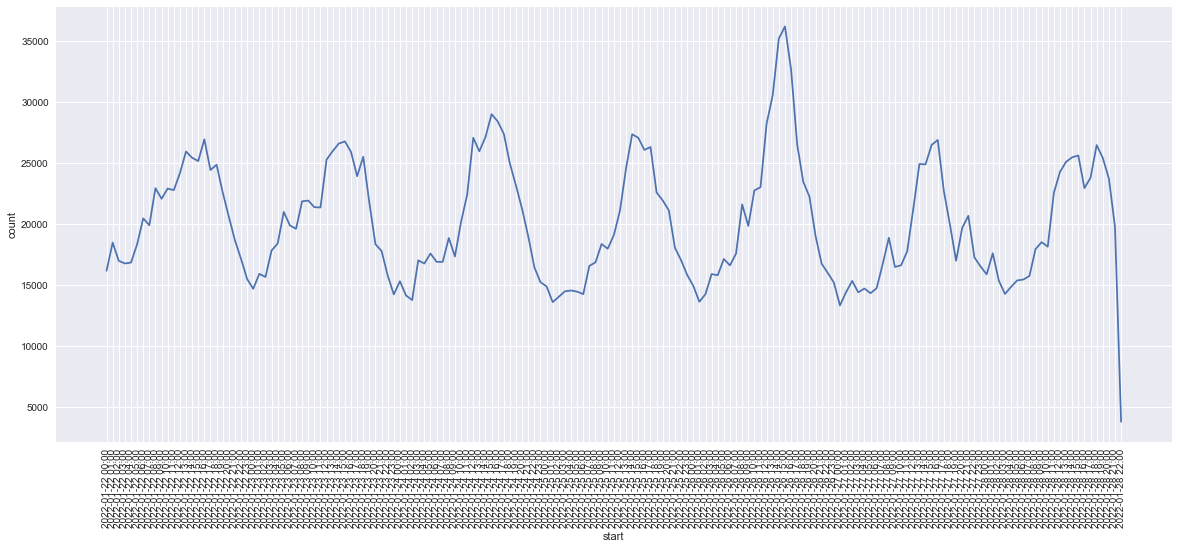

In [184]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=df_counts, x="start", y="count")
ax.tick_params(axis='x', rotation=90);

### BTC price by hour

In [105]:
df_btc_usd = pd.read_csv('data/btc_usd_hourly.csv', )  
df_btc_usd.head(2)

,time,high,low,open,volumefrom,volumeto,close
0,2022-01-21 07:00:00,39173.58,38575.80,38697.49,1758.17,68334552.69,39142.31
1,2022-01-21 08:00:00,39294.17,39030.88,39142.31,1288.39,50434328.22,39170.84


In [106]:
df_btc_usd['time'] = df_btc_usd['time'].apply(timestamp_to_hour)
df_btc_usd.head(2)

,time,high,low,open,volumefrom,volumeto,close
0,2022-01-21 07:00,39173.58,38575.80,38697.49,1758.17,68334552.69,39142.31
1,2022-01-21 08:00,39294.17,39030.88,39142.31,1288.39,50434328.22,39170.84


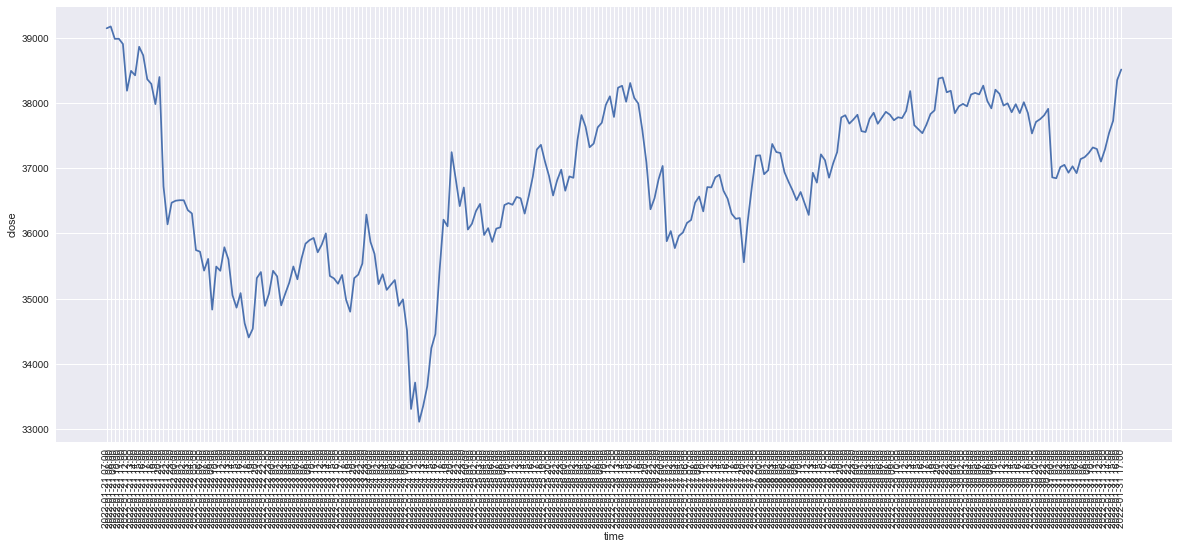

In [107]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=df_btc_usd, x="time", y="close")
ax.tick_params(axis='x', rotation=90);

In [319]:
df_btc_usd_diff = df_btc_usd.copy()
df_btc_usd_diff['diff'] = df_btc_usd_diff['close'].diff()
df_btc_usd_diff['diff_high_low'] = df_btc_usd_diff['high']-df_btc_usd_diff['low']
df_btc_usd_diff.set_index('time', inplace=True)

In [320]:
df_btc_usd_diff.head()

,high,low,open,volumefrom,volumeto,close,diff,diff_high_low
time,,,,,,,,
2022-01-21 07:00,39173.58,38575.80,38697.49,1758.17,68334552.69,39142.31,NaN,597.78
2022-01-21 08:00,39294.17,39030.88,39142.31,1288.39,50434328.22,39170.84,28.53,263.29
2022-01-21 09:00,39191.28,38953.29,39170.84,1549.57,60508276.18,38980.45,-190.39,237.99
2022-01-21 10:00,39090.91,38878.86,38980.45,1272.89,49626815.02,38981.85,1.40,212.05
2022-01-21 11:00,38986.50,38694.25,38981.85,1454.38,56453857.47,38901.98,-79.87,292.25


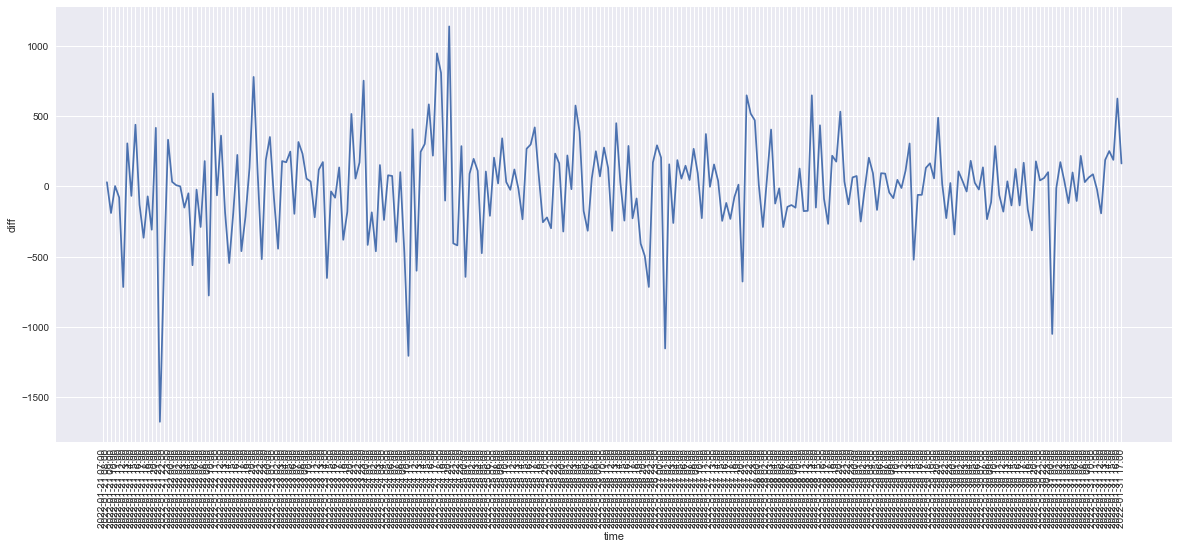

In [124]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=df_btc_usd_diff, x='time', y='diff')
ax.tick_params(axis='x', rotation=90);

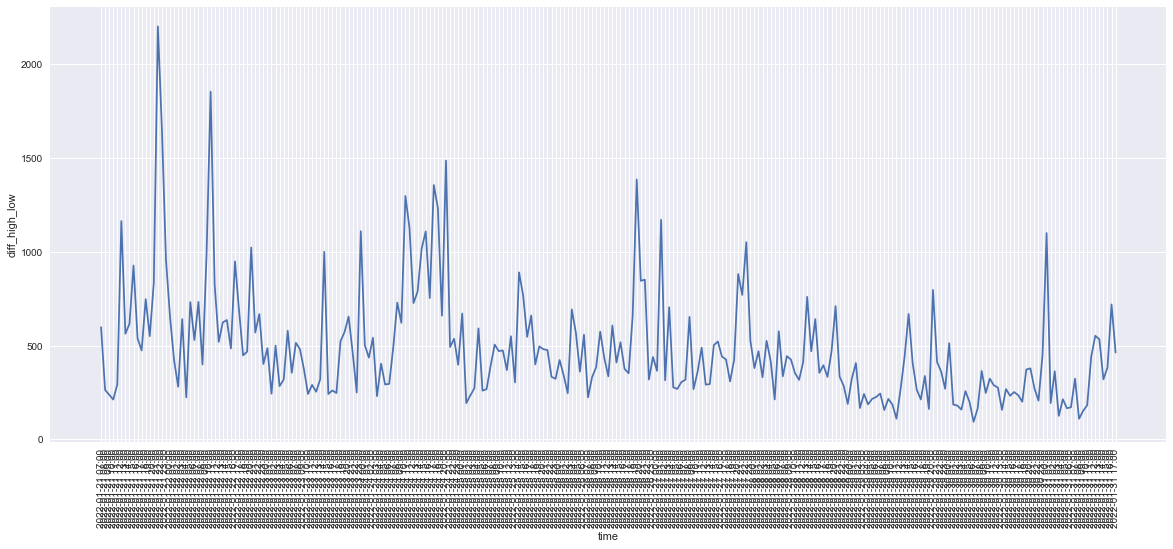

In [125]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=df_btc_usd_diff, x='time', y='diff_high_low')
ax.tick_params(axis='x', rotation=90);

### Tweet data

In [103]:
df_tweet_data = pd.read_csv('data/tweet_data.csv')  
df_tweet_data.head(2)

,tweet_id,author_id,created_at,source,retweet_count,reply_count,like_count,text
0,1487185499915706371,613649581,2022-01-28 22:07:08+00:00,Twitter Web App,0,2,2,@FamiLee_Farm @0xBingBong I first dissented in...
1,1487185295757905920,19721574,2022-01-28 22:06:19+00:00,Twitter for iPhone,22,7,105,A disaster.\n\nThe sooner aid agencies worldwi...


In [104]:
df_tweet_data.created_at = df_tweet_data['created_at'].apply(timestamp_to_hour)
df_tweet_data.head(2)

,tweet_id,author_id,created_at,source,retweet_count,reply_count,like_count,text
0,1487185499915706371,613649581,2022-01-28 22:00,Twitter Web App,0,2,2,@FamiLee_Farm @0xBingBong I first dissented in...
1,1487185295757905920,19721574,2022-01-28 22:00,Twitter for iPhone,22,7,105,A disaster.\n\nThe sooner aid agencies worldwi...


In [172]:
df_tweet_data_group = df_tweet_data.drop(columns=['text','tweet_id', 'author_id']).groupby(['created_at']).sum()
df_tweet_data_group.reset_index(inplace=True)
df_tweet_data_group = df_tweet_data_group.rename(columns={'created_at': 'time'})
df_tweet_data_group.set_index('time', inplace=True)
df_tweet_data_group

,retweet_count,reply_count,like_count
time,,,
2022-01-22 00:00,697,1171,6578
2022-01-22 01:00,933,833,5380
2022-01-22 02:00,180,192,886
2022-01-22 03:00,103,100,1033
2022-01-22 04:00,604,2531,7321
...,...,...,...
2022-01-28 18:00,4144,943,22828
2022-01-28 19:00,738,709,9009
2022-01-28 20:00,906,573,7527


### Sentiment analysis

In [96]:
df_tweet_sentiment = pd.read_csv('data/tweet_labeled.csv')  
df_tweet_sentiment.head()

,created_at,text,label
0,2022-01-28 22:07:08+00:00,@FamiLee_Farm @0xBingBong I first dissented in...,negative
1,2022-01-28 22:06:19+00:00,A disaster.\n\nThe sooner aid agencies worldwi...,negative
2,2022-01-28 22:03:07+00:00,With the very real threat of the government tr...,negative
3,2022-01-28 22:03:03+00:00,Bitcoin mining's energy use has more than trip...,neutral
4,2022-01-28 22:02:27+00:00,Tori Zero NFT Project Launched a Joint Coopera...,positive


In [97]:
df_tweet_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4766 entries, 0 to 4765
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  4766 non-null   object
 1   text        4766 non-null   object
 2   label       4766 non-null   object
dtypes: object(3)
memory usage: 111.8+ KB


In [99]:
df_tweet_sentiment.created_at = df_tweet_sentiment.created_at.apply(lambda x: timestamp_to_hour(x))

In [101]:
df_tweet_sentiment.head()

,created_at,text,label
0,2022-01-28 22:00,@FamiLee_Farm @0xBingBong I first dissented in...,negative
1,2022-01-28 22:00,A disaster.\n\nThe sooner aid agencies worldwi...,negative
2,2022-01-28 22:00,With the very real threat of the government tr...,negative
3,2022-01-28 22:00,Bitcoin mining's energy use has more than trip...,neutral
4,2022-01-28 22:00,Tori Zero NFT Project Launched a Joint Coopera...,positive


In [173]:
df_tweet_sentiment_counts = df_tweet_sentiment.drop(columns='text').groupby(['created_at', 'label']).size().unstack()
df_tweet_sentiment_counts.reset_index(inplace=True)
df_tweet_sentiment_counts = df_tweet_sentiment_counts.rename(columns={'created_at': 'time'})
df_tweet_sentiment_counts.set_index('time', inplace=True)
df_tweet_sentiment_counts.head()

label,negative,neutral,positive
time,,,
2022-01-22 00:00,7.0,14.0,6.0
2022-01-22 01:00,2.0,10.0,11.0
2022-01-22 02:00,1.0,4.0,10.0
2022-01-22 03:00,4.0,7.0,3.0
2022-01-22 04:00,5.0,8.0,6.0


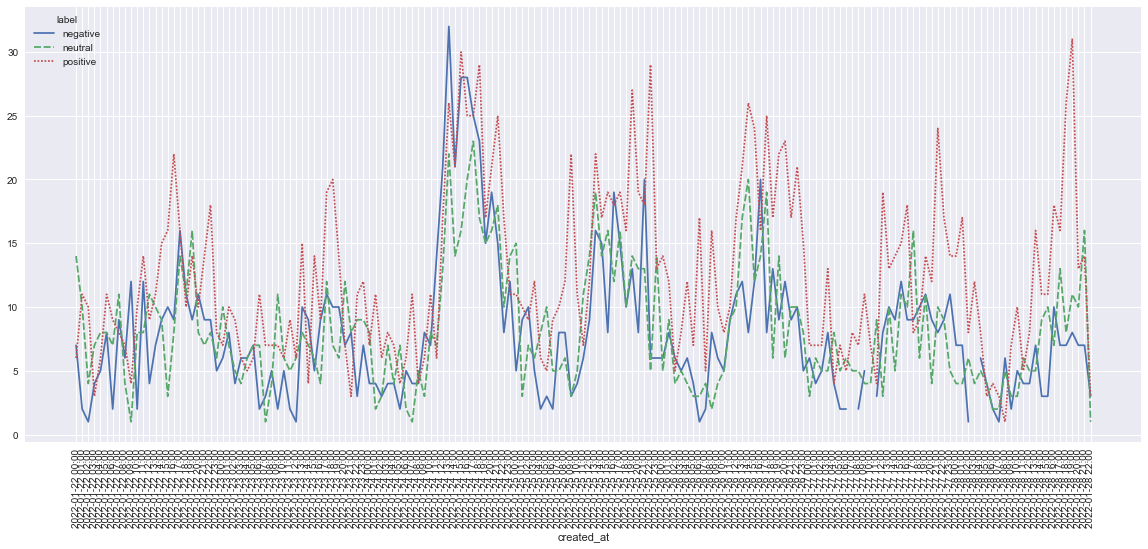

In [88]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=df_tweet_sentiment_counts)
ax.tick_params(axis='x', rotation=90);

### Concatenate dataframes

Having the date as the index has several advantages, among others, easy visualization with dates on the x-axis, and the functionality to resample the data.


In [204]:
df_tweet_sentiment_counts

label,negative,neutral,positive
time,,,
2022-01-22 00:00,7.0,14.0,6.0
2022-01-22 01:00,2.0,10.0,11.0
2022-01-22 02:00,1.0,4.0,10.0
2022-01-22 03:00,4.0,7.0,3.0
2022-01-22 04:00,5.0,8.0,6.0
...,...,...,...
2022-01-28 18:00,7.0,8.0,26.0
2022-01-28 19:00,8.0,11.0,31.0
2022-01-28 20:00,7.0,10.0,13.0


In [205]:
df_tweet_data_group

,retweet_count,reply_count,like_count
time,,,
2022-01-22 00:00,697,1171,6578
2022-01-22 01:00,933,833,5380
2022-01-22 02:00,180,192,886
2022-01-22 03:00,103,100,1033
2022-01-22 04:00,604,2531,7321
...,...,...,...
2022-01-28 18:00,4144,943,22828
2022-01-28 19:00,738,709,9009
2022-01-28 20:00,906,573,7527


In [321]:
df_btc_usd_diff

,high,low,open,volumefrom,volumeto,close,diff,diff_high_low
time,,,,,,,,
2022-01-21 07:00,39173.58,38575.80,38697.49,1758.17,6.833455e+07,39142.31,NaN,597.78
2022-01-21 08:00,39294.17,39030.88,39142.31,1288.39,5.043433e+07,39170.84,28.53,263.29
2022-01-21 09:00,39191.28,38953.29,39170.84,1549.57,6.050828e+07,38980.45,-190.39,237.99
2022-01-21 10:00,39090.91,38878.86,38980.45,1272.89,4.962682e+07,38981.85,1.40,212.05
2022-01-21 11:00,38986.50,38694.25,38981.85,1454.38,5.645386e+07,38901.98,-79.87,292.25
...,...,...,...,...,...,...,...,...
2022-01-31 13:00,37378.11,36844.68,37100.04,1891.52,7.033098e+07,37286.89,186.85,533.43
2022-01-31 14:00,37537.51,37218.04,37286.89,1723.68,6.444947e+07,37537.04,250.15,319.47
2022-01-31 15:00,37911.21,37528.54,37537.04,2782.20,1.050991e+08,37724.71,187.67,382.67


In [207]:
df_counts

,count
start,
2022-01-22 00:00,16166
2022-01-22 01:00,18475
2022-01-22 02:00,16978
2022-01-22 03:00,16762
2022-01-22 04:00,16834
...,...
2022-01-28 18:00,26471
2022-01-28 19:00,25426
2022-01-28 20:00,23729


In [322]:
final_df = df_btc_usd_diff.join([df_tweet_data_group,df_counts, df_tweet_sentiment_counts])
final_df.dropna(subset=['positive'], inplace=True)
final_df

,high,low,open,volumefrom,volumeto,close,diff,diff_high_low,retweet_count,reply_count,like_count,count,negative,neutral,positive
time,,,,,,,,,,,,,,,
2022-01-22 00:00,36811.86,36160.28,36469.30,2830.58,1.032656e+08,36500.60,31.30,651.58,697.0,1171.0,6578.0,16166.0,7.0,14.0,6.0
2022-01-22 01:00,36624.40,36203.95,36500.60,2214.58,8.061853e+07,36508.18,7.58,420.45,933.0,833.0,5380.0,18475.0,2.0,10.0,11.0
2022-01-22 02:00,36569.48,36289.21,36508.18,1460.57,5.319548e+07,36507.27,-0.91,280.27,180.0,192.0,886.0,16978.0,1.0,4.0,10.0
2022-01-22 03:00,36694.32,36053.64,36507.27,2372.57,8.633400e+07,36355.49,-151.78,640.68,103.0,100.0,1033.0,16762.0,4.0,7.0,3.0
2022-01-22 04:00,36437.02,36213.05,36355.49,1145.55,4.162005e+07,36305.21,-50.28,223.97,604.0,2531.0,7321.0,16834.0,5.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28 18:00,37130.73,36797.91,36853.20,1902.39,7.032675e+07,37070.22,217.02,332.82,4144.0,943.0,22828.0,26471.0,7.0,8.0,26.0
2022-01-28 19:00,37254.00,36786.03,37070.22,1847.49,6.837532e+07,37245.37,175.15,467.97,738.0,709.0,9009.0,25426.0,8.0,11.0,31.0
2022-01-28 20:00,37869.29,37159.63,37245.37,2488.91,9.337495e+07,37776.13,530.76,709.66,906.0,573.0,7527.0,23729.0,7.0,10.0,13.0


In [219]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 2022-01-22 00:00 to 2022-01-28 22:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   high           167 non-null    float64
 1   low            167 non-null    float64
 2   open           167 non-null    float64
 3   volumefrom     167 non-null    float64
 4   volumeto       167 non-null    float64
 5   close          167 non-null    float64
 6   diff           167 non-null    float64
 7   diff_high_low  167 non-null    float64
 8   retweet_count  167 non-null    float64
 9   reply_count    167 non-null    float64
 10  like_count     167 non-null    float64
 11  count          167 non-null    float64
 12  negative       164 non-null    float64
 13  neutral        167 non-null    float64
 14  positive       167 non-null    float64
dtypes: float64(15)
memory usage: 20.9+ KB


In [334]:
df_corr = final_df.corr()
df_corr

,high,low,open,volumefrom,volumeto,close,diff,diff_high_low,retweet_count,reply_count,like_count,count,negative,neutral,positive
high,1.000000,0.965874,0.968810,-0.162641,-0.110562,0.973015,0.028958,-0.124251,0.002828,-0.173243,0.022088,0.001181,-0.180413,0.014152,0.154742
low,0.965874,1.000000,0.978204,-0.365440,-0.315754,0.973152,0.002310,-0.377017,-0.047678,-0.217084,-0.014451,-0.063315,-0.273397,-0.065596,0.072754
open,0.968810,0.978204,1.000000,-0.301921,-0.251991,0.940070,-0.156278,-0.283017,-0.042230,-0.206171,-0.005758,-0.052051,-0.257605,-0.057022,0.088623
volumefrom,-0.162641,-0.365440,-0.301921,1.000000,0.997799,-0.260123,0.115846,0.818372,0.405499,0.336266,0.329592,0.390600,0.569856,0.469601,0.425157
volumeto,-0.110562,-0.315754,-0.251991,0.997799,1.000000,-0.211273,0.113584,0.814261,0.409306,0.331291,0.331548,0.390603,0.555129,0.471423,0.433838
close,0.973015,0.973152,0.940070,-0.260123,-0.211273,1.000000,0.189879,-0.248632,0.008181,-0.164860,0.030260,-0.017101,-0.199356,0.004139,0.138992
diff,0.028958,0.002310,-0.156278,0.115846,0.113584,0.189879,1.000000,0.094702,0.145294,0.116092,0.104231,0.100338,0.165811,0.176176,0.147438
diff_high_low,-0.124251,-0.377017,-0.283017,0.818372,0.814261,-0.248632,0.094702,1.000000,0.192762,0.212124,0.134344,0.246775,0.402292,0.301895,0.274631
retweet_count,0.002828,-0.047678,-0.042230,0.405499,0.409306,0.008181,0.145294,0.192762,1.000000,0.722565,0.886465,0.453511,0.462743,0.544350,0.504283
reply_count,-0.173243,-0.217084,-0.206171,0.336266,0.331291,-0.164860,0.116092,0.212124,0.722565,1.000000,0.765503,0.376804,0.504070,0.487429,0.359126


In [335]:
final_df_log = np.log2(final_df)
final_df_log['diff'] = final_df_log['close'].diff()*100
final_df_log['count'] = final_df_log['count']/10
final_df_log.head()

,high,low,open,volumefrom,volumeto,close,diff,diff_high_low,retweet_count,reply_count,like_count,count,negative,neutral,positive
time,,,,,,,,,,,,,,,
2022-01-22 00:00,15.167883,15.142118,15.154395,11.466882,26.621784,15.155633,NaN,9.347799,9.445015,10.193525,12.683433,1.398068,2.807355,3.807355,2.584963
2022-01-22 01:00,15.160518,15.143859,15.155633,11.112817,26.264608,15.155932,0.029957,8.715790,9.865733,9.702173,12.393390,1.417329,1.000000,3.321928,3.459432
2022-01-22 02:00,15.158352,15.147253,15.155932,10.512316,25.664800,15.155896,-0.003596,8.130674,7.491853,7.584963,9.791163,1.405138,0.000000,2.000000,3.321928
2022-01-22 03:00,15.163269,15.137857,15.155896,11.212235,26.363425,15.149886,-0.601055,9.323460,6.686501,6.643856,10.012625,1.403291,2.000000,2.807355,1.584963
2022-01-22 04:00,15.153117,15.144222,15.149886,10.161825,25.310776,15.147889,-0.199664,7.807162,9.238405,11.305492,12.837825,1.403909,2.321928,3.000000,2.584963


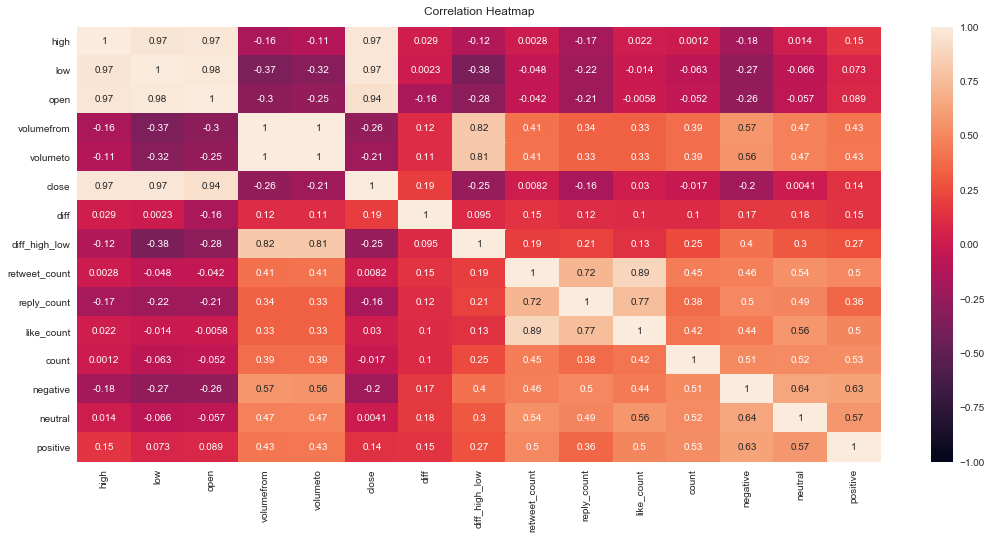

In [336]:
plt.figure(figsize=(18, 8))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

This measures the strength and direction of the linear relationship between two variables. It cannot capture nonlinear relationships between two variables and cannot differentiate between dependent and independent variables.1

A value of exactly 1.0 means there is a perfect positive relationship between the two variables. For a positive increase in one variable, there is also a positive increase in the second variable. A value of -1.0 means there is a perfect negative relationship between the two variables. This shows that the variables move in opposite directions—for a positive increase in one variable, there is a decrease in the second variable. If the correlation between two variables is 0, there is no linear relationship between them.

The strength of the relationship varies in degree based on the value of the correlation coefficient. For example, a value of 0.2 shows there is a positive correlation between two variables, but it is weak and likely unimportant. Analysts in some fields of study do not consider correlations important until the value surpasses at least 0.8. However, a correlation coefficient with an absolute value of 0.9 or greater would represent a very strong relationship.

https://www.investopedia.com/terms/c/correlationcoefficient.asp

In [342]:
final_df_diff = final_df.copy()
final_df_diff.drop(columns='diff')
final_df_diff = final_df.diff()
final_df_diff.dropna(inplace=True)
final_df_diff.head()

,high,low,open,volumefrom,volumeto,close,diff,diff_high_low,retweet_count,reply_count,like_count,count,negative,neutral,positive
time,,,,,,,,,,,,,,,
2022-01-22 01:00,-187.46,43.67,31.30,-616.00,-22647059.71,7.58,-23.72,-231.13,236.0,-338.0,-1198.0,2309.0,-5.0,-4.0,5.0
2022-01-22 02:00,-54.92,85.26,7.58,-754.01,-27423049.55,-0.91,-8.49,-140.18,-753.0,-641.0,-4494.0,-1497.0,-1.0,-6.0,-1.0
2022-01-22 03:00,124.84,-235.57,-0.91,912.00,33138514.41,-151.78,-150.87,360.41,-77.0,-92.0,147.0,-216.0,3.0,3.0,-7.0
2022-01-22 04:00,-257.30,159.41,-151.78,-1227.02,-44713944.10,-50.28,101.50,-416.71,501.0,2431.0,6288.0,72.0,1.0,1.0,3.0
2022-01-22 05:00,-83.53,-591.14,-50.28,998.27,35620490.94,-561.77,-511.49,507.61,2571.0,-1122.0,11654.0,1496.0,3.0,0.0,5.0


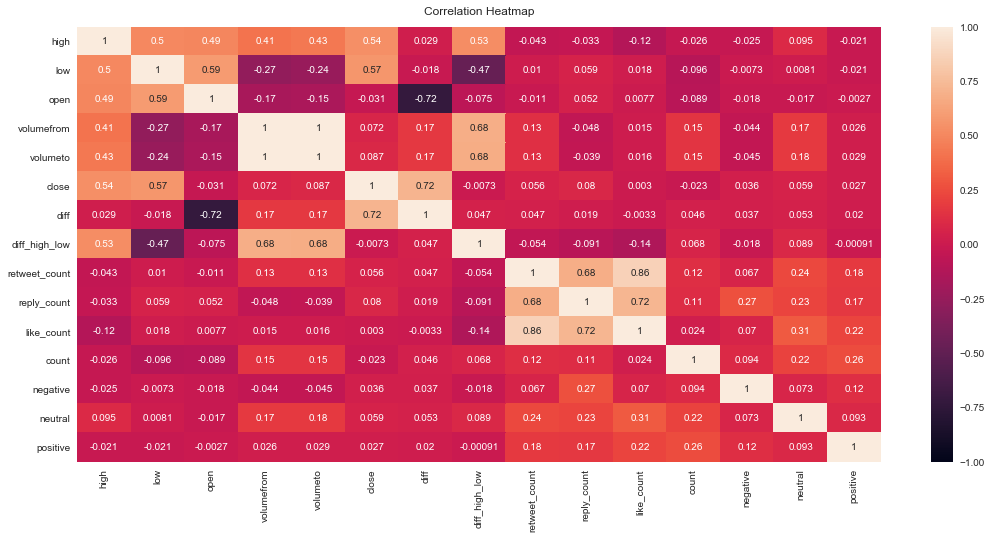

In [343]:
plt.figure(figsize=(18, 8))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(final_df_diff.corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [365]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=(sign(x)) * (log(abs(x)))(final_df_diff[['close','negative']]))
ax.tick_params(axis='x', rotation=90);

NameError: name 'sign' is not defined

<Figure size 1440x576 with 0 Axes>

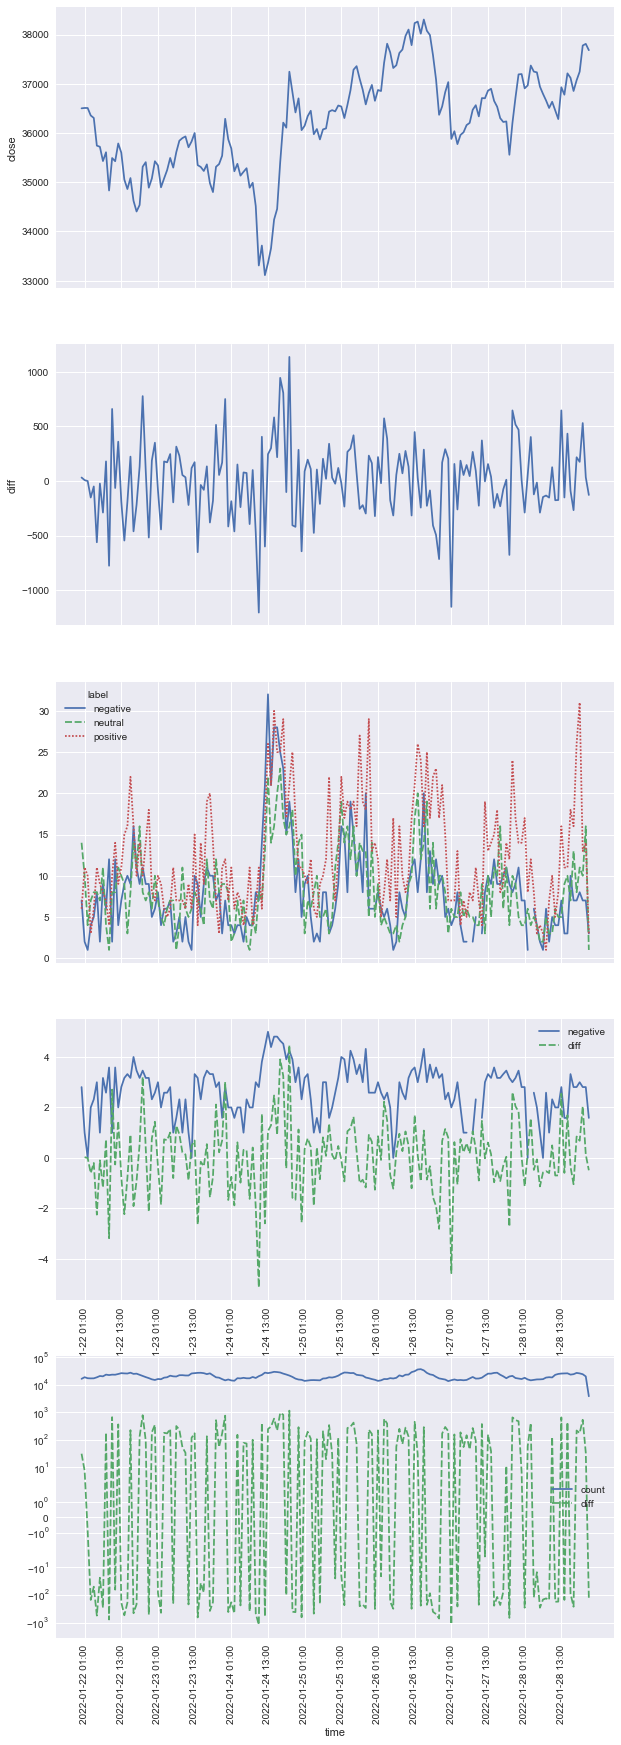

In [367]:
plt.figure(figsize=(10,30))

plt.subplot(5, 1, 1)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax = sns.lineplot(data=final_df, x='time', y='close')
ax.set_xticks(ax.get_xticks()[1::12])
ax.tick_params(axis='x', rotation=90);

plt.subplot(5, 1, 2)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax = sns.lineplot(data=final_df, x='time', y='diff')
ax.set_xticks(ax.get_xticks()[1::12])
ax.tick_params(axis='x', rotation=90);

plt.subplot(5, 1, 3)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax = sns.lineplot(data=df_tweet_sentiment_counts)
ax.set_xticks(ax.get_xticks()[1::12])
ax.tick_params(axis='x', rotation=90);

plt.subplot(5, 1, 4)
ax = sns.lineplot(data=final_df_log[['negative','diff']])
ax.tick_params(axis='x', rotation=90)
ax.set_xticks(ax.get_xticks()[1::12]);

plt.subplot(5, 1, 5)
plt.yscale('symlog')
ax = sns.lineplot(data=final_df[['count','diff']])

ax.tick_params(axis='x', rotation=90)
ax.set_xticks(ax.get_xticks()[1::12]);


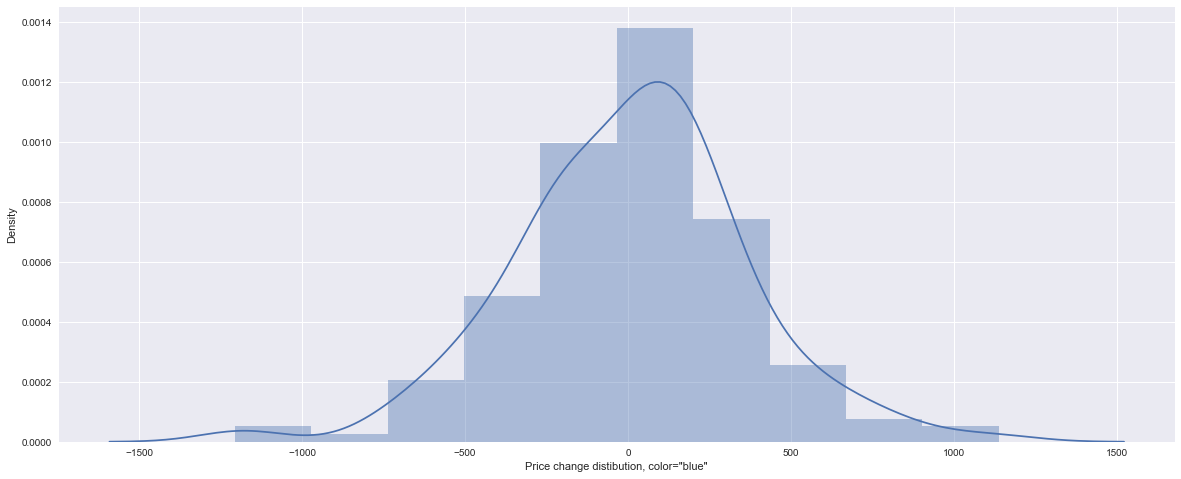

In [378]:
plt.figure(figsize=(20,8))
ax = sns.distplot(final_df['diff'], bins=10, axlabel='Price change distibution, color="blue"')

In [ ]:
autocorelation + lag